In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


# Import Connectome and Atlas data

In [2]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Quick check of the variables inside each file
#print("AAL_labels keys:", AAL_labels.keys())
print("PET_maps keys:", PET_maps.keys())
print("RSNsAAL keys:", RSNsAAL.keys())
print("SC keys:", SC_mat.keys())

PET_maps keys: dict_keys(['__header__', '__version__', '__globals__', 'Maps_Labels', 'NM_PET_Maps'])
RSNsAAL keys: dict_keys(['__header__', '__version__', '__globals__', 'Yeo_AAL'])
SC keys: dict_keys(['__header__', '__version__', '__globals__', 'C'])


In [3]:
# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])
RSNs

array([1, 6, 4, 5, 5, 5, 5, 6, 1, 3, 4, 6, 6, 4, 3, 6, 3, 6, 6, 4, 4, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 5, 3, 6, 6, 1, 4, 0, 0, 0, 1, 1, 4, 6, 4,
       4, 4, 4, 6, 4, 1, 1, 0, 0, 3, 4, 1, 6, 6, 3, 5, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 6, 3, 6, 3, 4, 6, 6, 4, 1, 1, 6, 5, 5, 5, 5, 4,
       6, 1])

In [4]:
# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 
RSN_ordered

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6])

In [5]:
# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

print(f"Loaded {len(ROIs_labels)} ROI labels")
print("Example:", ROIs_labels[:10])

Loaded 90 ROI labels
Example: ['L Precentral', 'L Frontal Sup', 'L Front Sup Orb', 'L Front Mid', 'L Front Mid Orb', 'L Front Inf Ope', 'L Front Inf Tri', 'L Front Inf Orb', 'L Rolandic Oper', 'L Supp Motor Ar']


In [6]:
# Structural Connectivity
SC=SC_mat['C']

In [7]:
# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)

L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
ordr=np.hstack((L_ids,R_ids[::-1]))
maps=maps[:,ordr]

In [8]:
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

In [9]:
PET_dict.keys()

dict_keys(['5HT1a', '5HT1b', '5HT2a', '5HT4', '5HT6', '5HTT', 'A4B2', 'CB1', 'D1', 'D2', 'DAT', 'GABAa', 'H3', 'M1', 'mGluR5', 'MOR', 'NET', 'NMDA', 'VAChT'])

# Import fMRI data

In [10]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")

# Path to your file
#file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load the .mat file
mat_data = sio.loadmat(file_path)

# Inspect available keys (variables inside the .mat file)
print("Keys in .mat file:", mat_data.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'timeseries_CNT24_symm', 'timeseries_MCS24_symm', 'timeseries_UWS24_symm'])


In [11]:
# Path
file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load
mat_data = sio.loadmat(file_path)

# Extract groups
ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

print("Controls:", ts_controls.shape)
print("MCS:", ts_mcs.shape)
print("UWS:", ts_uws.shape)

Controls: (1, 13)
MCS: (1, 11)
UWS: (1, 10)


In [12]:
# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

print(f"Controls: {len(controls)} subjects → subj[0] shape {controls[0].shape}")
print(f"MCS:      {len(mcs)} subjects → subj[0] shape {mcs[0].shape}")
print(f"UWS:      {len(uws)} subjects → subj[0] shape {uws[0].shape}")


Controls: 13 subjects → subj[0] shape (192, 90)
MCS:      11 subjects → subj[0] shape (192, 90)
UWS:      10 subjects → subj[0] shape (192, 90)


In [61]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [62]:
T

192

In [14]:
groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

In [15]:
cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

# Personalized ANN

In [16]:
# -----------------------
# Train ANN for each participant
# -----------------------
# Assuming `groups` is like:
# groups = {"CNT": [np.ndarray(T,N), ...], "MCS": [...], "UWS": [...]}

S=3

models_by_group = train_models_for_groups(
    groups,
    steps=S,
    num_epochs=100,
    lr=1e-3,
    l2=5e-5,
    save_dir=None  # or None to skip saving
)

# Quick summary print
for g, lst in models_by_group.items():
    print(f"{g}: {len(lst)} trained models")
    if lst:
        h = lst[0]["history"]
        print(f"  example final losses — train {h['train_loss'][-1]:.6f}, test {h['test_loss'][-1]:.6f}")


=== Group: CNT — 13 subjects ===
[OK]  CNT[0] — T=192, N=90, W=189 | final train=0.052203, test=0.503545 (2.3s)
[OK]  CNT[1] — T=192, N=90, W=189 | final train=0.039270, test=0.437574 (1.0s)
[OK]  CNT[2] — T=192, N=90, W=189 | final train=0.058053, test=0.518049 (1.0s)
[OK]  CNT[3] — T=192, N=90, W=189 | final train=0.037765, test=0.526033 (1.0s)
[OK]  CNT[4] — T=192, N=90, W=189 | final train=0.076793, test=0.611978 (1.0s)
[OK]  CNT[5] — T=192, N=90, W=189 | final train=0.043725, test=0.450264 (1.0s)
[OK]  CNT[6] — T=192, N=90, W=189 | final train=0.047433, test=0.659287 (1.3s)
[OK]  CNT[7] — T=192, N=90, W=189 | final train=0.036382, test=0.735843 (1.3s)
[OK]  CNT[8] — T=192, N=90, W=189 | final train=0.056504, test=0.473637 (1.1s)
[OK]  CNT[9] — T=192, N=90, W=189 | final train=0.036421, test=0.578063 (1.0s)
[OK]  CNT[10] — T=192, N=90, W=189 | final train=0.146923, test=0.420973 (1.0s)
[OK]  CNT[11] — T=192, N=90, W=189 | final train=0.046754, test=0.511221 (1.2s)
[OK]  CNT[12] — 

In [17]:
# import torch
# import pickle
# import os

# save_path = "../results/ANNs_DOC/models_by_group.pkl"
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# # Create a serializable version: save weights separately, keep history/meta in pickle
# serializable = {}

# for group, entries in models_by_group.items():
#     serializable[group] = []
#     for i, entry in enumerate(entries):
#         model = entry["model"]

#         # Save model weights per subject
#         weights_path = f"../results/ANNs_DOC/{group}_sub{entry['subject_idx']}_weights.pt"
#         torch.save(model.state_dict(), weights_path)

#         # Copy all non-model info
#         meta_entry = {k: v for k, v in entry.items() if k != "model"}
#         meta_entry["weights_path"] = weights_path
#         serializable[group].append(meta_entry)

# # Save the metadata + paths
# with open(save_path, "wb") as f:
#     pickle.dump(serializable, f)

# print(f"✅ Saved metadata to {save_path}")

In [18]:
models_by_group['CNT'][0].keys()

dict_keys(['model', 'history', 'subject_idx', 'shapes', 'train_time_s'])

# Effective Connectivity (and dynamic EC)

In [89]:
ECs_sim={}
ECts_sim={}
dECs_sim={}
pert_strength=.1
for g in groups_id:
    print(g)
    ECs_sim[g]={}
    ECts_sim[g]={}
    dECs_sim[g]={}
    for isu in range(len(groups[g])):
        # Pull the matching raw series Z (T, N)
        Z = groups[g][isu][:T,:]

        # Prepare windowed data for EC methods that need it
        X, Y = multi2one(Z, steps=S)  # X: (W, S*N), Y: (W, N)

        # --- EC ---
        ECs_sim[g][isu]= model_EC(models_by_group[g][isu]['model'], input_X=X, target_Y=Y, pert_strength=pert_strength) #(N, N)
        ECt_est = model_ECt(models_by_group[g][isu]['model'], input_X=X, target_Y=Y, pert_strength=pert_strength) #(M, N, N)


        M, N, _ = ECt_est.shape
        triu_idx = np.triu_indices(N, k=1)
        ECt_est_edges = ECt_est[:, triu_idx[0], triu_idx[1]]  # shape → (M, E)
        
        ECts_sim[g][isu]= ECt_est_edges
        dECs_sim[g][isu]= np.corrcoef(ECt_est_edges)

CNT
MCS
UWS


In [112]:
Mean_EC_sim={}
for g in groups_id:
    Mean_EC_sim[g]={}
    for isu in range(len(groups[g])):
        ec=ECs_sim[g][isu][np.triu_indices(N, k=1)]
        #Mean_EC_sim[g][isu]=np.sum(np.where(ec<0,1,0))#/np.sum(np.where(ec<0,1,0))
        #Mean_EC_sim[g][isu]=np.sum(np.where(ec<0,1,0))#/np.sum(np.where(ec<0,1,0))
        Mean_EC_sim[g][isu]=np.mean(ECs_sim[g][isu][np.triu_indices(N, k=1)])

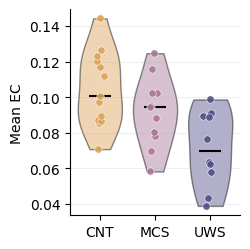

In [113]:
data = {g: np.asarray(list(Mean_EC_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Mean EC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

In [114]:
Fluidity_dEC_sim={}
for g in groups_id:
    Fluidity_dEC_sim[g]={}
    for isu in range(len(groups[g])):
        Fluidity_dEC_sim[g][isu]=np.var(dECs_sim[g][isu][np.triu_indices(T-S, k=1)])

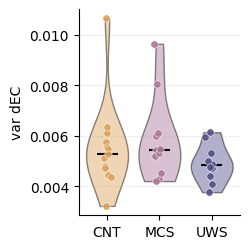

In [115]:
data = {g: np.asarray(list(Fluidity_dEC_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("var dEC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

# To Adjust

# Effective COnnectivity classification

In [13]:
# -----------------------
# Compute FC and EC from the personalized ANN for each participant
# -----------------------
conn = compute_FC_EC_for_all(groups, models_by_group, ec_method="perturb", pert_strength=.1)
# Or:
#conn = compute_FC_EC_for_all(groups, models_by_group, ec_method="jacobian")
#
# Access example:
#conn["CNT"][0]["FC"].shape # -> (N, N)
#conn["CNT"][0]["EC"].shape # -> (N, N)
#conn["CNT"][0]["meta"]    #  -> dict with steps/T/N/method


=== Connectivity: CNT (13 models) ===
[OK] CNT[0] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[1] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[2] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[3] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[4] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[5] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[6] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[7] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[8] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[9] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[10] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[11] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)
[OK] CNT[12] -> FC, EC computed (T=192, N=90, steps=3, method=perturb)

=== Connectivity: MCS (11 models) ===
[OK] MCS[

CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


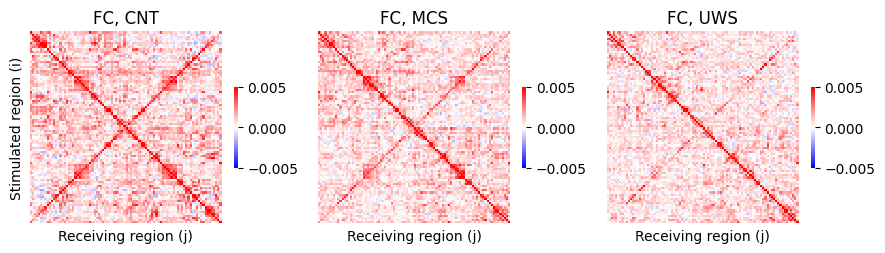

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EC'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = 0.005#max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='bwr', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"FC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


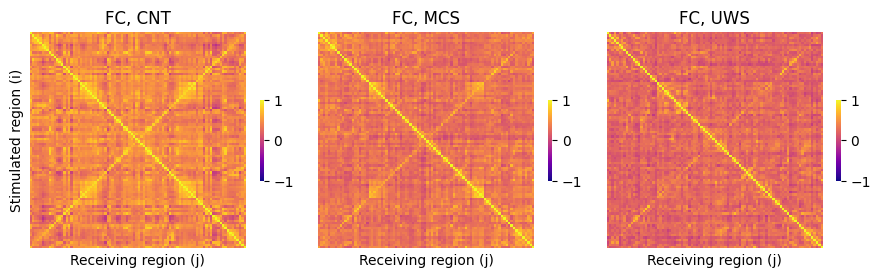

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['FC'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = 1#max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='plasma', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"FC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_FC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


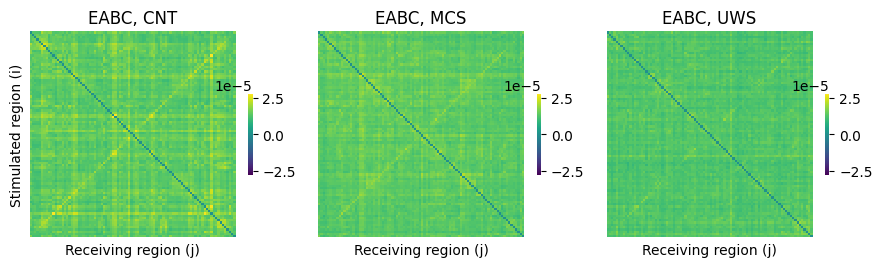

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EABC_Cosine'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='viridis', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"EABC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EABC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


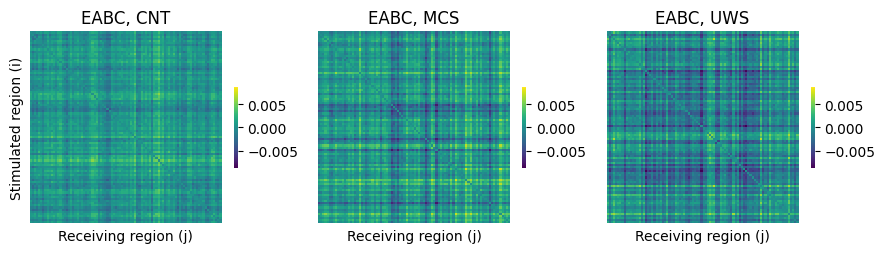

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EABC_L2'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='viridis', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"EABC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EABC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


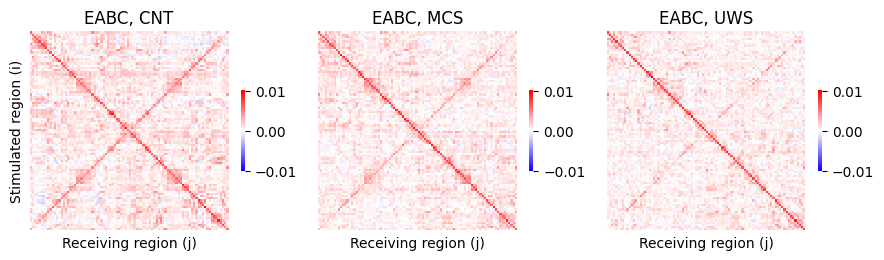

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EC_min'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='bwr', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"EABC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EABC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


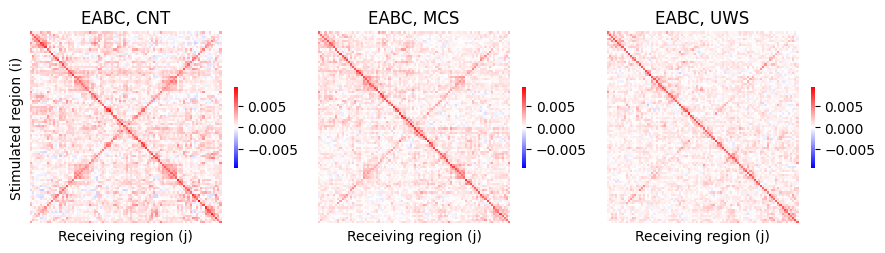

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EC_max'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='bwr', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"EABC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EABC_matrices.png", dpi=300, transparent=True)
plt.show()


CNT: averaged 13 subjects, shape (90, 90)
MCS: averaged 11 subjects, shape (90, 90)
UWS: averaged 10 subjects, shape (90, 90)


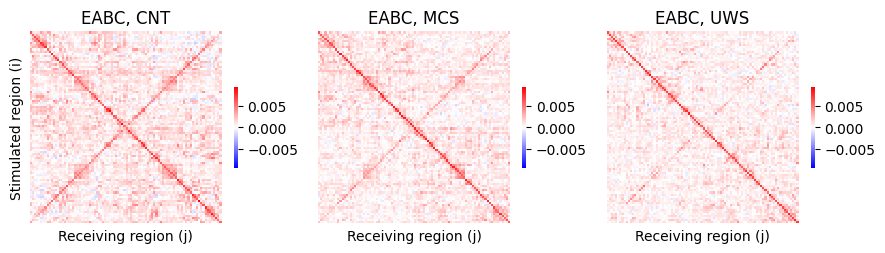

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Compute group-average EC matrices
# ----------------------------------------------------
groups_id = list(conn.keys())
mean_ECs = {}

for g in groups_id:
    mats = [conn[g][s]['EC_rand'] for s in range(len(conn[g]))]
    mean_ECs[g] = np.nanmean(np.stack(mats, axis=0), axis=0)
    print(f"{g}: averaged {len(mats)} subjects, shape {mean_ECs[g].shape}")

# ----------------------------------------------------
# Plot: 1 row × 3 columns (CNT, MCS, UWS)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

vmax = max(np.abs(mean_ECs[g]).max() for g in groups_id)  # symmetric color range
vmin = -vmax

for i, g in enumerate(groups_id):
    ax = axs[i]
    sns.heatmap(mean_ECs[g], cmap='bwr', center=0, square=True,
                vmin=vmin, vmax=vmax,
                cbar_kws={'shrink':0.3}, #label': 'FC'
                ax=ax)
    ax.set_title(f"EABC, {g}")
    ax.set_xlabel("Receiving region (j)")
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stimulated region (i)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Group_mean_EABC_matrices.png", dpi=300, transparent=True)
plt.show()


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, permutation_test_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------------------------------------
# 1️⃣  Build feature matrix (flatten EC matrices)
# ----------------------------------------------------
def build_features(conn):
    X_list, y_list = [], []
    for g in conn.keys():            # e.g. 'CNT', 'MCS', 'UWS'
        for subj in range(len(conn[g])):  # subject index
            EC = conn[g][subj]['FC']  # (N, N)
            feat = EC.flatten()
            X_list.append(feat)
            y_list.append(g)
    X = np.vstack(X_list)
    y = np.array(y_list)
    return X, y, EC.shape  # return shape for later reshaping

X, y, ec_shape = build_features(conn)
le = LabelEncoder()
y_enc = le.fit_transform(y)
groups_id = le.classes_
print(f"Feature matrix: {X.shape}, Groups: {groups_id}")


# ----------------------------------------------------
# 2️⃣  Define classifier (best config)
# ----------------------------------------------------
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, multi_class='multinomial', C=1.0)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------------
# 3️⃣  Evaluate accuracy and generate predictions
# ----------------------------------------------------
acc = cross_val_score(clf, X, y_enc, cv=cv, scoring='accuracy')
print(f"\nMean CV accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")

y_pred = cross_val_predict(clf, X, y_enc, cv=cv)

# # ----------------------------------------------------
# # 4️⃣  Permutation test for significance
# # ----------------------------------------------------
# score, perm_scores, pval = permutation_test_score(
#     clf, X, y_enc, cv=cv, n_permutations=1000, random_state=42
# )
# print(f"Permutation test: acc={score:.3f}, p={pval:.4f}")

Feature matrix: (34, 8100), Groups: ['CNT' 'MCS' 'UWS']


/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/sit


Mean CV accuracy: 0.738 ± 0.164


/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/sit

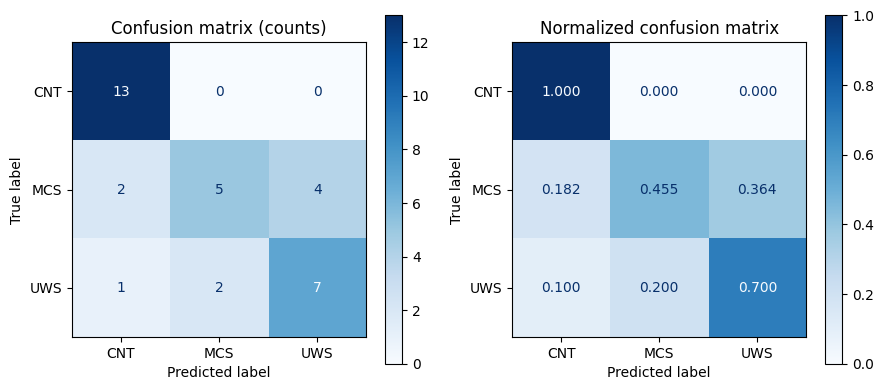

/Users/giovanni/anaconda3/envs/neuro310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Model saved as EC_classifier_logreg.joblib
✅ Feature importance saved as EC_feature_importance.npy


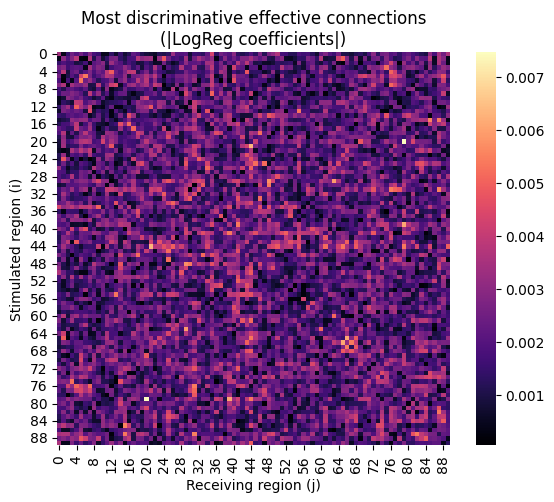


Top 5% most discriminative EC connections (i → j):
  From ROI 0 → ROI 35 : 0.0043
  From ROI 1 → ROI 24 : 0.0047
  From ROI 1 → ROI 64 : 0.0042
  From ROI 1 → ROI 65 : 0.0049
  From ROI 2 → ROI 76 : 0.0042
  From ROI 3 → ROI 40 : 0.0042
  From ROI 3 → ROI 75 : 0.0052
  From ROI 4 → ROI 12 : 0.0049
  From ROI 4 → ROI 17 : 0.0040
  From ROI 4 → ROI 43 : 0.0048


In [39]:
# ----------------------------------------------------
# 5️⃣  Confusion matrices
# ----------------------------------------------------
cm = confusion_matrix(y_enc, y_pred)
cm_norm = confusion_matrix(y_enc, y_pred, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(ax=axs[0], cmap="Blues", values_format=".0f")
axs[0].set_title("Confusion matrix (counts)")

# 👇 Here’s the update — 3 decimal places for normalized values
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(ax=axs[1], cmap="Blues", values_format=".3f")
axs[1].set_title("Normalized confusion matrix")
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 6️⃣  Fit model on full data and save
# ----------------------------------------------------
clf.fit(X, y_enc)
joblib.dump(clf, "EC_classifier_logreg.joblib")
print("✅ Model saved as EC_classifier_logreg.joblib")

# ----------------------------------------------------
# 7️⃣  Extract feature importance (connection weights)
# ----------------------------------------------------
lr = clf.named_steps["logisticregression"]
coef = lr.coef_  # shape (n_classes, N*N)
mean_importance = np.mean(np.abs(coef), axis=0)
importance_matrix = mean_importance.reshape(ec_shape)

np.save("EC_feature_importance.npy", importance_matrix)
print("✅ Feature importance saved as EC_feature_importance.npy")

# ----------------------------------------------------
# 8️⃣  Visualize top discriminative connections
# ----------------------------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(importance_matrix, cmap="magma", square=True)
plt.title("Most discriminative effective connections\n(|LogReg coefficients|)")
plt.xlabel("Receiving region (j)")
plt.ylabel("Stimulated region (i)")
plt.tight_layout()
plt.savefig("EC_feature_importance_heatmap.png", dpi=300, transparent=True)
plt.show()

threshold = np.percentile(importance_matrix, 95)
strong_edges = np.argwhere(importance_matrix > threshold)
print(f"\nTop 5% most discriminative EC connections (i → j):")
for (i, j) in strong_edges[:10]:
    print(f"  From ROI {i} → ROI {j} : {importance_matrix[i, j]:.4f}")

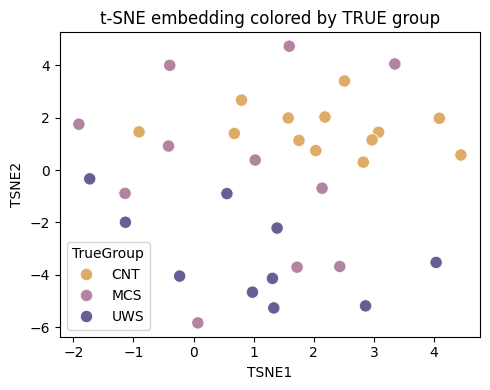

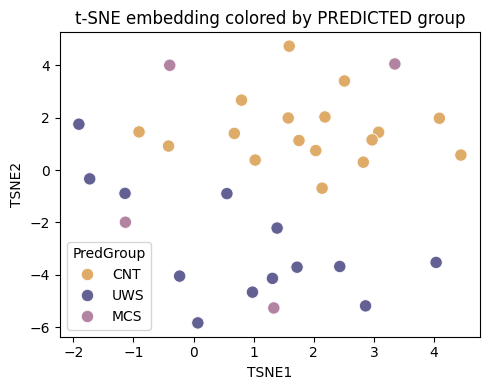

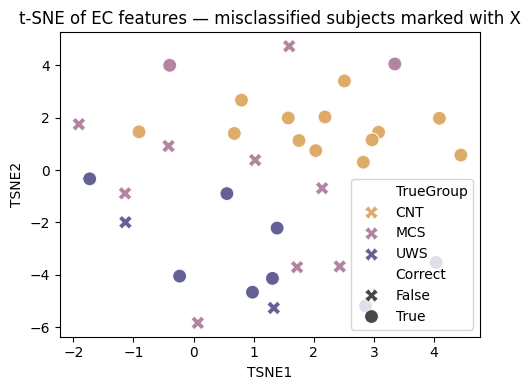

In [55]:
from sklearn.manifold import TSNE

# Assume you already have:
# X  (subjects × features)
# y_enc  (true encoded labels)
# y_pred (predicted labels)
# le     (LabelEncoder with class names)

# ---- t-SNE projection ----
X_embedded = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(X)

df_tsne = pd.DataFrame({
    "TSNE1": X_embedded[:, 0],
    "TSNE2": X_embedded[:, 1],
    "TrueGroup": le.inverse_transform(y_enc),
    "PredGroup": le.inverse_transform(y_pred)
})

# ---- Visualization 1: True group labels ----
plt.figure(figsize=(5,4))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2",
                hue="TrueGroup", palette=cols,
                s=80, alpha=0.9)
plt.title("t-SNE embedding colored by TRUE group")
plt.tight_layout()
plt.show()

# ---- Visualization 2: Predicted group labels ----
plt.figure(figsize=(5,4))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2",
                hue="PredGroup", palette=cols,
                s=80, alpha=0.9)
plt.title("t-SNE embedding colored by PREDICTED group")
plt.tight_layout()
plt.show()

# ---- Visualization 3: Highlight misclassified subjects ----
df_tsne["Correct"] = (df_tsne["TrueGroup"] == df_tsne["PredGroup"])
plt.figure(figsize=(5,4))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2",
                hue="TrueGroup", style="Correct",
                markers={True:"o", False:"X"},
                palette=cols,
                s=100, alpha=0.9)
plt.title("t-SNE of EC features — misclassified subjects marked with X")
plt.tight_layout()
plt.show()
